In [ ]:
%%capture
!git lfs install
!git clone https://huggingface.co/cointegrated/LaBSE-en-ru
!pip install datasets sentence_transformers

In [ ]:
import os
import gc
import pickle
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from collections import OrderedDict

from pathlib import Path
from dataclasses import dataclass
from typing import Any

import torch
from torch import nn
from torch.nn import functional as F

from datasets import load_dataset
from numpy.lib.stride_tricks import sliding_window_view
from transformers import AutoTokenizer, AutoModel

from sentence_transformers import SentenceTransformer

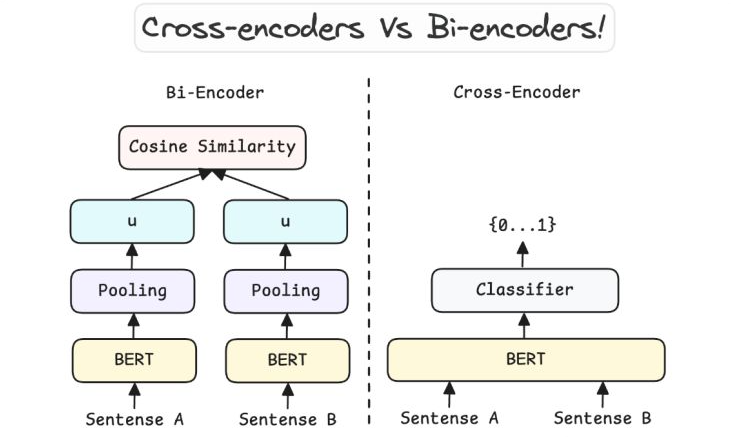

## Bi-encoder

- Вычисляет векторное представление фиксированного размера (эмбеддинг) заданных текстов или изображений

- Быстрый расчет эмбеддингов и их сходства

- Применимо для широкого спектра задач, таких как семантический поиск, кластеризация, классификация, поиск парафраз и многое другое

- Часто используется в качестве первого шага в двухэтапном процессе поиска, где модель cross-encoder (реранжировщик) используется для повторного ранжирования первых k результатов от bi-encoder

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

embeddings = model.encode(sentences)
print(embeddings.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(3, 384)


In [ ]:
similarities = model.similarity(embeddings, embeddings)
print(similarities)

tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])


In [ ]:
sentences = [
  'где можно взять лодку на прокат?',
  'взятие тракторов для пользования не предусмотрено',
  'небольшой катер обычно берут в аренду у берега',
]

embeddings = model.encode(sentences)
similarities = model.similarity(embeddings, embeddings)
print(similarities)

tensor([[1.0000, 0.6160, 0.5206],
        [0.6160, 1.0000, 0.5637],
        [0.5206, 0.5637, 1.0000]])


## Cross-encoder

- Вычисляет показатель схожести для заданных пар текстов

- В целом обеспечивает более высокую производительность по сравнению с bi-encoder

- Часто работает медленнее, чем bi-encoder, поскольку требует вычислений для каждой конкретной пары, а не для каждого текста

- Часто используются для повторного ранжирования первых k результатов из модели bi-encoder

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

# 1. Load a pretrained CrossEncoder model
model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

query = "A man is eating pasta."

corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]

ranks = model.rank(query, corpus)

print("Query: ", query)
for rank in ranks:
    print(f"{rank['score']:.2f}\t{corpus[rank['corpus_id']]}")

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/148 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Query:  A man is eating pasta.
0.67	A man is eating food.
0.34	A man is eating a piece of bread.
0.08	A man is riding a horse.
0.07	A man is riding a white horse on an enclosed ground.
0.01	The girl is carrying a baby.
0.01	Two men pushed carts through the woods.
0.01	A monkey is playing drums.
0.01	A woman is playing violin.
0.01	A cheetah is running behind its prey.


In [ ]:
sentence_combinations = [[query, sentence] for sentence in corpus]
scores = model.predict(sentence_combinations)

# Sort the scores in decreasing order to get the corpus indices
ranked_indices = np.argsort(scores)[::-1]
print("Scores:", scores)
print("Indices:", ranked_indices)

Scores: [0.6732374  0.3410256  0.00542465 0.07569344 0.00525378 0.00536814
 0.06676235 0.00534824 0.00516717]
Indices: [0 1 3 6 2 5 7 4 8]


In [ ]:
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L6-v2")

query = "где можно взять лодку на прокат?"

corpus = [
    'взятие тракторов для пользования не предусмотрено',
    'небольшой катер обычно берут в аренду у берега',
]

ranks = model.rank(query, corpus)

print("Query: ", query)
for rank in ranks:
    print(f"{rank['score']:.2f}\t{corpus[rank['corpus_id']]}")

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Query:  где можно взять лодку на прокат?
7.73	взятие тракторов для пользования не предусмотрено
6.72	небольшой катер обычно берут в аренду у берега


## Двухэтапный пайплайн

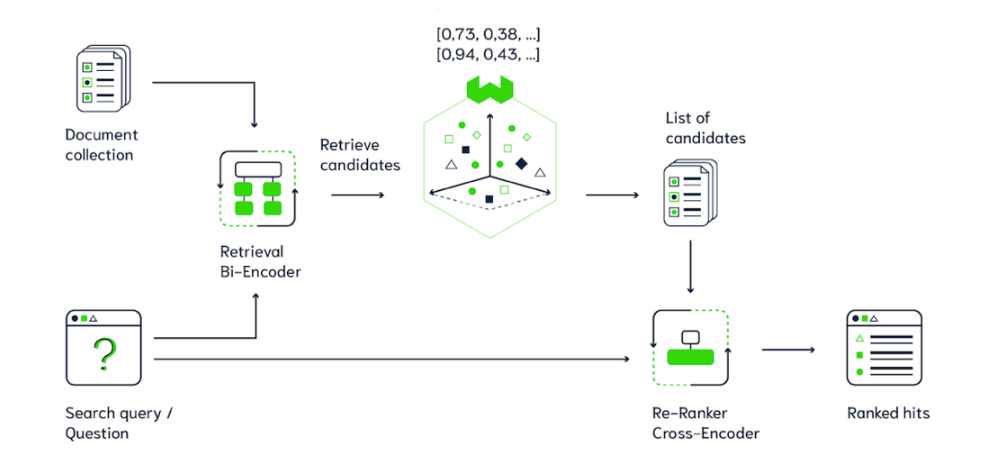

## Tune Cross-Encoder

In [ ]:
os.listdir('./')

['.config', 'LaBSE-en-ru', 'sample_data']

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = './CrossEncoderModel'

### Cross-Encoder head

In [ ]:
class Model(nn.Module):
    """
    labse - base bert-like model
    pooler layer as input
    then classification head - binary classification to predict if this pair is TRUE question-answer
    """
    def __init__(self):
        super().__init__()
        self.labse  = AutoModel.from_pretrained('./LaBSE-en-ru')
        self.tokenizer = AutoTokenizer.from_pretrained('./LaBSE-en-ru', use_fast=True)
        n_dim = 768
        self.cls = nn.Sequential(
            OrderedDict([
                ('dropout', torch.nn.Dropout(.0)),
                ('fc_1' , nn.Linear(n_dim, n_dim*2)),
                ('relu_1' , nn.GELU()),
                ('layernorm_1' , nn.LayerNorm(n_dim*2, eps=1e-12)),
                ('fc_2' , nn.Linear(n_dim*2, n_dim)),
                ('relu_2' , nn.GELU()),
                ('layernorm_2' , nn.LayerNorm(n_dim, eps=1e-12)),
                ('fc_3' , nn.Linear(n_dim, 2, bias=False)),
           ]))

    def forward(self, text):
        token = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
        model_output = self.labse(**token)
        result = self.cls(model_output.pooler_output)
        return result

### Загрузка датасетов

In [ ]:
dataset_1 = load_dataset("RussianNLP/russian_super_glue", name='danetqa')
df_1 = (
    pd.concat([dataset_1['train'].to_pandas(), dataset_1['validation'].to_pandas(), dataset_1['test'].to_pandas()])
    .iloc[:, :2]
)

The repository for RussianNLP/russian_super_glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/RussianNLP/russian_super_glue.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


DaNetQA.zip:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/821 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/805 [00:00<?, ? examples/s]

In [ ]:
dataset_2 = load_dataset("RussianNLP/russian_super_glue", name='muserc')
df_2 = (
    pd.concat([dataset_2['train'].to_pandas(), dataset_2['validation'].to_pandas(), dataset_2['test'].to_pandas()])
    .loc[:, ['question', 'paragraph']]
    .set_axis(['question', 'passage'], axis=1)
)

MuSeRC.zip:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11950 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2235 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7614 [00:00<?, ? examples/s]

In [ ]:
dataset_3 = load_dataset("xquad", 'xquad.ru')
df_3 = (
    dataset_3['validation'].to_pandas()
    .loc[:, ['question', 'context']]
    .set_axis(['question', 'passage'], axis=1)
)

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/322k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1190 [00:00<?, ? examples/s]

In [ ]:
df = (
    pd.concat([df_1, df_2, df_3])
    .dropna()
    .map(str)
    .drop_duplicates()
    .loc[lambda df: df['passage'].str.len() < 2000]
)

In [ ]:
assert df.shape == (9550, 2)

In [ ]:
df.sample(5)

,question,passage
6031,Сколько раз Зайцева ошиблась при стрельбе на д...,"""(1) Тренер женской сборной России по биатлону..."
1475,Является ли точным перевод названия русского ж...,"Русское название жанра, научная фантастика, не..."
670,Какой потомок Чингисхана разграбил Багдад?,"Захват Багдада, Самарканда, Ургенча, Киева и В..."
5239,От чего умер аниматор и геймдизайнер Монти Оум?,(1) Аниматор и геймдизайнер Монти Оум умер в б...
9522,Кого вызывали на бис десять раз?,"(1) В день премьеры спектакля, в котором получ..."


In [ ]:
with open('df.pickle', 'wb') as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

### train/test split

In [ ]:
with open('df.pickle', 'rb') as f:
    df = pickle.load(f)

In [ ]:
assert df.shape == (9550, 2)

In [ ]:
df_train = df.sample(frac=.8).iloc[:, :2]
df_val = df.drop(df_train.index).iloc[:, :2]

### Utility functions

In [ ]:
def get_batch(df, n):
    """return batch witn n samples form given dataframe (test, val)
    each batch contains n samples. n/2 positive, and n/2 negative"""
    positive = df.sample(n=n//2).assign(targets = 1)
    negative = pd.concat([df[['question']].sample(n//2).reset_index(drop=True),
                          df[['passage']].sample(n//2).reset_index(drop=True)],
                         axis=1,
                        ).assign(targets = 0)
    result = pd.concat([positive, negative])
    result = result.sample(frac=1)
    texts = result.iloc[:, [0, 1]].values.tolist()
    targets = result.iloc[:, 2].values.tolist()
    return texts, targets

In [ ]:
def estimate_loss():
    """calculate train and val loss during the training. Val loss - main metric of quality of the checkpoint"""
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)
        for i in range(eval_iters):
            text, target = get_batch(df_train if split == 'train' else df_val, batch_size)
            loss, accuracy = calculate_loss(text, target)
            losses[i] = loss.item()
            accuracies[i] = accuracy.item()
        out[f'{split}_loss'] = losses.mean().item()
        out[f'{split}_accuracy'] = accuracies.mean().item()
    return out

In [ ]:
def calculate_loss(text, target):
    """given batch and target labels returns two quality metrics: loss and accuracy"""
    logit = pac.model(text)
    target = torch.tensor(target, dtype=torch.long).to(device)
    loss = F.cross_entropy(logit, target)
    accuracy = sum(logit.to('cpu').argmax(1) == target.to('cpu')) / target.to('cpu').size(0)
    return loss, accuracy

In [ ]:
def set_lr(i, optimizer):
    """set learning rate function. Used in training process. Given the training step number (i) and optimizer object set learning rate"""
    if i < iterations * 0.2:  # warmup stage
        lr = learning_rate * 1e-2
    elif i < iterations * 0.8:  # main training stage
        lr = learning_rate
    else:
        lr = learning_rate * 1e-1  # closing stage
    optimizer.param_groups[0]['lr'] = lr

In [ ]:
def train_model(pac):
    """train model. Model is in the pac object
    model related info we get from pac object
    general info and functions - from global scope"""
    pac.model.train()
    for i in range(iterations):
        set_lr(i, pac.optimizer)
        text, target = get_batch(df_train, batch_size)
        loss, _ = calculate_loss(text, target)  # do not need accuracy return here
        pac.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pac.model.parameters(), max_norm = 1)
        pac.optimizer.step()
        if i % eval_interval == 0:
            pac.model.eval()
            losses = estimate_loss()
            print(f"step {i}: train loss {losses['train_loss']:.8f}, val loss {losses['val_loss']:.8f} ", end='')
            print(f"train accuracy {losses['train_accuracy']:.0%}, val accuracy {losses['val_accuracy']:.0%}")
            pac.train_loss_history.append(losses['train_loss'])
            pac.val_loss_history.append(losses['val_loss'])
            if losses['val_loss'] < pac.best_val_loss:
                print(f"            saving checkpoint with val loss {losses['val_loss']:.8f}")
                pac.best_val_loss = losses['val_loss']
                checkpoint = {  'model': pac.model.state_dict(),
                                'optimizer': pac.optimizer.state_dict(),
                                'best_val_loss': pac.best_val_loss,
                                'train_loss_history' : pac.train_loss_history,
                                'val_loss_history' : pac.val_loss_history,}
                torch.save(checkpoint, model_path)
            pac.model.train()
    pac.model.eval()

In [ ]:
def load_model_pac(pac, **kwargs):
    """load model from disk. On disk we maintain only one model, without choice
    pac object will be filled with loaded model"""
    if Path(model_path).exists():
        state = torch.load(model_path, **kwargs)
        pac.model = Model().to(device)
        pac.model.load_state_dict(state['model'])
        pac.optimizer = torch.optim.AdamW(pac.model.parameters())
        pac.optimizer.load_state_dict(state['optimizer'])
        pac.best_val_loss = state['best_val_loss']
        pac.train_loss_history = state['train_loss_history']
        pac.val_loss_history = state['val_loss_history']
    else:
        print('WARNING!!! no file to get model. pac is returned without changes')

In [ ]:
def plot_losses(pac):
    """plot smoothed losses for train and val
    x-axis is not very informative, due to smoothing (collapce several eval steps)
    so this plot is used only for basic visual understanding of trand in training"""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    smooth = 8 if len(pac.train_loss_history) > 8 else 2
    ax[0].plot(sliding_window_view(pac.train_loss_history, window_shape = smooth).mean(1))
    ax[1].plot(sliding_window_view(pac.val_loss_history, window_shape = smooth).mean(1))
    ax[0].set_title('train_loss_history')
    ax[1].set_title('val_loss_history')
    fig.suptitle('plot losses')
    plt.show()

In [ ]:
@dataclass
class ModelPackage:
    """main object. contain all key data concerning the model. we create one instance only and work with it"""
    model : Any = None
    optimizer : Any = None
    best_val_loss : Any = None
    train_loss_history : Any =None
    val_loss_history : Any = None

### Создание модели

In [ ]:
base_model = Model().to(device)
torch.nn.init.zeros_(base_model.cls.fc_1.bias)
torch.nn.init.zeros_(base_model.cls.fc_2.bias)
base_optimizer = torch.optim.AdamW(base_model.parameters(), lr=5e-5)  # lr (learning rate) will be overriden by set_lr function every step of training
pac = ModelPackage(model=base_model, optimizer=base_optimizer, best_val_loss=1e+9, train_loss_history=[], val_loss_history=[])  # key object with model

In [ ]:
# used if we start with existing model on disk
# load_model_pac(pac)  # use if we save and load on the same device
load_model_pac(pac, map_location=torch.device('cpu')) # map_locations is needed if we train on gpu, save to disk. But after that switch to cpu device

WARNING!!! no file to get model. pac is returned without changes


### Stage 1. Обучаем классификационную голову

In [ ]:
learning_rate = 9e-5
batch_size = 8
iterations = 1000
eval_times = 25
eval_interval = iterations // eval_times
eval_iters = 25

In [ ]:
for name, parameter in pac.model.named_parameters():
    if name.startswith('cls'):
        parameter.requires_grad = True
    else:
        parameter.requires_grad = False

In [ ]:
%%time
train_model(pac)

step 0: train loss 0.79434204, val loss 0.84253281 train accuracy 49%, val accuracy 47%
            saving checkpoint with val loss 0.84253281
step 40: train loss 0.72895128, val loss 0.73083901 train accuracy 51%, val accuracy 54%
            saving checkpoint with val loss 0.73083901
step 80: train loss 0.73933810, val loss 0.75047898 train accuracy 50%, val accuracy 48%
step 120: train loss 0.72737700, val loss 0.74894518 train accuracy 50%, val accuracy 46%
step 160: train loss 0.77979141, val loss 0.72691327 train accuracy 47%, val accuracy 49%
            saving checkpoint with val loss 0.72691327
step 200: train loss 0.73842537, val loss 0.70837355 train accuracy 55%, val accuracy 57%
            saving checkpoint with val loss 0.70837355
step 240: train loss 0.67721772, val loss 0.69953179 train accuracy 57%, val accuracy 52%
            saving checkpoint with val loss 0.69953179
step 280: train loss 0.66282630, val loss 0.69691622 train accuracy 58%, val accuracy 52%
         

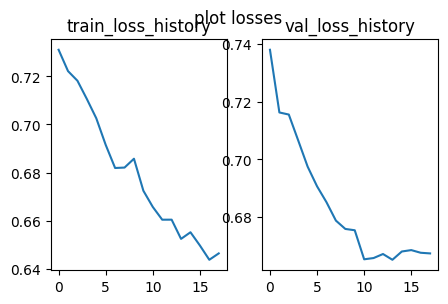

In [ ]:
plot_losses(pac)

### Stage 2. Обучаем модель

In [ ]:
learning_rate = 1e-5
batch_size = 8
iterations = 2000
eval_times = 50
eval_interval = iterations // eval_times
eval_iters = 25

In [ ]:
load_model_pac(pac)  # load best checkpoing form Stage 1

In [ ]:
for name, parameter in pac.model.named_parameters():
    parameter.requires_grad = True

In [ ]:
%%time
train_model(pac)

step 0: train loss 0.62056971, val loss 0.65974677 train accuracy 64%, val accuracy 57%
step 40: train loss 0.60139680, val loss 0.67657489 train accuracy 68%, val accuracy 56%
step 80: train loss 0.63600236, val loss 0.65805173 train accuracy 63%, val accuracy 61%
step 120: train loss 0.63196391, val loss 0.65817535 train accuracy 64%, val accuracy 61%
step 160: train loss 0.65297884, val loss 0.67642617 train accuracy 62%, val accuracy 54%
step 200: train loss 0.64779961, val loss 0.66599917 train accuracy 62%, val accuracy 57%
step 240: train loss 0.65189588, val loss 0.63614422 train accuracy 62%, val accuracy 66%
            saving checkpoint with val loss 0.63614422
step 280: train loss 0.63324755, val loss 0.68176687 train accuracy 63%, val accuracy 56%
step 320: train loss 0.65520835, val loss 0.65025485 train accuracy 60%, val accuracy 63%
step 360: train loss 0.69063985, val loss 0.65499985 train accuracy 54%, val accuracy 56%
step 400: train loss 0.62856668, val loss 0.65337

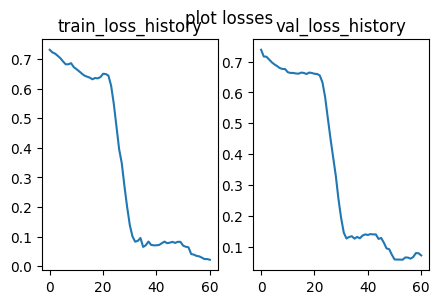

In [ ]:
plot_losses(pac)

### Stage 3. Обучение с регуляризацией

In [ ]:
learning_rate = 5e-6
batch_size = 8
iterations = 1000
eval_times = 100
eval_interval = iterations // eval_times
eval_iters = 25

In [ ]:
load_model_pac(pac)

In [ ]:
for name, parameter in pac.model.named_parameters():
    parameter.requires_grad = True

In [ ]:
pac.optimizer.param_groups[0]['weight_decay'] = 0.03
pac.model.cls[0].p = 0.1

In [ ]:
%%time
train_model(pac)

step 0: train loss 0.04170637, val loss 0.14940931 train accuracy 99%, val accuracy 98%
step 10: train loss 0.03645839, val loss 0.04218672 train accuracy 100%, val accuracy 99%
step 20: train loss 0.03492201, val loss 0.02899744 train accuracy 100%, val accuracy 100%
step 30: train loss 0.07009687, val loss 0.00349390 train accuracy 99%, val accuracy 100%
step 40: train loss 0.07690234, val loss 0.11028317 train accuracy 99%, val accuracy 98%
step 50: train loss 0.03804936, val loss 0.05122509 train accuracy 100%, val accuracy 99%
step 60: train loss 0.02645021, val loss 0.10841665 train accuracy 100%, val accuracy 99%
step 70: train loss 0.00148024, val loss 0.06051510 train accuracy 100%, val accuracy 99%
step 80: train loss 0.04607423, val loss 0.03895911 train accuracy 100%, val accuracy 100%
step 90: train loss 0.00093880, val loss 0.05432785 train accuracy 100%, val accuracy 99%
step 100: train loss 0.01206180, val loss 0.05611590 train accuracy 100%, val accuracy 99%
step 110: 

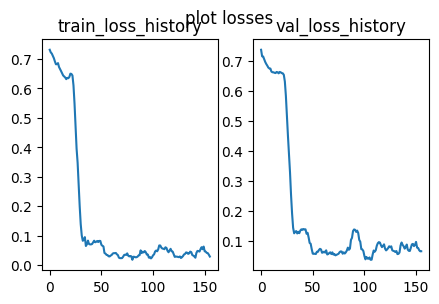

In [ ]:
plot_losses(pac)

### Проверим модель

In [ ]:
pac.model.eval();

In [ ]:
pac.model([
    ['где дают бананы?','фрукты можно купить везде, в т.ч. в магазине за углом, в т.ч. бананы']
])

tensor([[-4.0279,  4.1592]], device='cuda:0', grad_fn=<MmBackward0>)

In [ ]:
questions = ['где можно взять лодку на прокат?',
             'где можно взять лодку на прокат?']
answers = ['взятие тракторов для пользования не предусмотрено',
            'небольшой катер обычно берут в аренду у берега']
pac.model(list(zip(questions, answers))).argmax(1)

tensor([0, 1], device='cuda:0')

In [ ]:
questions = ['где можно взять лодку на прокат?',
             'где можно взять лодку на прокат?']
answers = ['взятие тракторов для пользования не предусмотрено',
            'небольшой катер обычно берут в аренду у берега']
pac.model(list(zip(questions, answers)))

tensor([[ 0.4957, -1.1107],
        [-2.0245,  1.8794]], device='cuda:0', grad_fn=<MmBackward0>)